<a href="https://colab.research.google.com/github/RoetGer/deep_learning_framework_appetizer/blob/main/dl_framework_appetizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An Appetizer for Deep Learning Frameworks (Keras, TF, PyTorch & Co)



## Why should you care?

The core selling points of DL frameworks are:

- Flexibility 
- Ease of use 

## What can you expect from this presentation?

- A demonstration of what these frameworks are capable of.
- The frameworks and the possibilities which come with them are huge, i.e. we
will only cover a fraction of them.
- The aim of this presentation is to spark interest in learning one of the frameworks, not turn you into a professional user!


## A quick introduction into Tensorflow 2.0

Most of the frameworks are basically "plug-in" replacements for numpy

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

tfl = tf.linalg

print(tf.__version__)

2.3.0


In [ ]:
# You can sample random variables
X = tf.random.normal(shape=(10, 4))
y = tf.random.normal(shape=(1, 10))

In [ ]:
X

<tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[ 2.9997802e-01,  6.6795148e-02, -2.0081093e+00, -3.0193716e-01],
       [-1.4067190e+00, -2.2354376e+00,  5.2987796e-01,  5.5395693e-01],
       [-6.1793453e-01,  5.8786184e-01, -1.4413153e-01,  5.2614850e-01],
       [ 8.4892249e-01,  1.4285388e+00, -1.8667804e+00, -2.1514452e-01],
       [ 2.5285143e-01,  1.3683176e+00,  1.1197956e+00,  1.0769231e+00],
       [ 7.4349618e-01,  1.7352816e+00,  1.1996388e+00,  1.1764905e+00],
       [ 2.9218301e-01, -9.8305571e-01, -5.2672964e-01, -6.6858396e-02],
       [-4.8412124e-04, -4.2379364e-01, -2.9578644e-01,  2.0964403e+00],
       [ 7.9661018e-01, -2.0831103e+00,  1.3588391e-01, -2.7381501e+00],
       [-6.4102340e-01,  7.0689106e-01,  7.6492846e-01, -1.2498299e+00]],
      dtype=float32)>

In [ ]:
# Do some simple linear algebra
print(tf.matmul(y, X))

# Or in short
y @ X

tf.Tensor([[-1.4530476 -4.028884  -4.6086655 -8.492169 ]], shape=(1, 4), dtype=float32)


<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[-1.4530476, -4.028884 , -4.6086655, -8.492169 ]], dtype=float32)>

In [ ]:
# Or more complicated linear algebra
XtX = tf.matmul(X, X, transpose_a=True)
tfl.cholesky(XtX)

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[ 2.21787   ,  0.        ,  0.        ,  0.        ],
       [ 1.4656838 ,  4.013509  ,  0.        ,  0.        ],
       [-0.9938571 ,  0.47372642,  3.2044249 ,  0.        ],
       [-0.7354815 ,  1.8273778 ,  0.10401838,  3.5823257 ]],
      dtype=float32)>

None of these things are particularly special or impressive, numpy can do these things and more :)

However, let's look at the following example what makes them amazing.

## Example - Empirical Covariance Matrix

In [ ]:
n = 50
dim = 4

samples = tf.random.normal(shape=(n, dim))
samples = samples - tf.reduce_mean(samples, axis=0)
emp_cov_mat = tf.matmul(samples, samples, transpose_a=True)

In [ ]:
def proj_psd_cone(X):
  '''
  Makes the matrix X positive semi-definite.

  Returns projected matrix, eigen-values, eigen-vectors
  '''
  eig_vals, eig_vecs = tfl.eigh(X)

  # Replace negative eigenvalues with 0.
  eig_vals = tf.where(eig_vals < 0, 0.0, eig_vals)
  
  return [
      eig_vecs @ tfl.diag(eig_vals) @ tf.transpose(eig_vecs),
      eig_vals,
      eig_vecs
  ]


def turn_vec_into_sym_mat(theta):
  '''
  Turns a vector into a symmetric matrix by interpreting the vector
  as the lower triangular matrix of the final matrix.
  '''
  low_tri_mat = tfp.math.fill_triangular(theta)
  
  upper_tri_mat = tf.transpose(low_tri_mat)
  upper_tri_mat = tfl.set_diag(upper_tri_mat, tf.zeros(low_tri_mat.shape[0]))
  
  full_mat = low_tri_mat + upper_tri_mat 

  return full_mat

# 1,2,3

# 1 0 
# 2 3

# 1 2
# 2 3

# xTKx >= 0 K is positive semidefinite
# => eigenvalues >= 0

@tf.function() # Tells Python/tensorflow to compile the computation graph
def func_to_optimize(theta, Sigma, penalty):
    
  full_mat = turn_vec_into_sym_mat(theta)

  full_mat, eig_vals, eig_vecs = proj_psd_cone(full_mat)

  full_mat += (1e-6)*tfl.eye(full_mat.shape[0])

  res = (
       tfl.trace(tf.matmul(full_mat, Sigma)) 
       - tfl.logdet(full_mat)
       + penalty * tf.reduce_sum(tf.abs(full_mat))
       - penalty * tf.reduce_sum(tf.where(eig_vals < 0, eig_vals, 0))
  )

  return res

In [ ]:

theta = tf.Variable(tfp.math.fill_triangular_inverse(tf.eye(dim)))
# -> Variable means, that the value can vary -> we can optimize with respect to
# it later on.
sparse_pen = 0.01

In [ ]:
tf.eye(2)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 0.],
       [0., 1.]], dtype=float32)>

In [ ]:
theta

<tf.Variable 'Variable:0' shape=(10,) dtype=float32, numpy=array([1., 0., 0., 0., 1., 1., 0., 0., 0., 1.], dtype=float32)>

In [ ]:
func_to_optimize(theta, emp_cov_mat, sparse_pen)

<tf.Tensor: shape=(), dtype=float32, numpy=196.14638>

Your task is now to minimize this function with respect to theta ...

In [ ]:
with tf.GradientTape() as tape:
  value = func_to_optimize(theta, emp_cov_mat, sparse_pen)

tape.gradient(value, theta)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([61.50865 ,  0.      ,  0.      ,  0.      , 40.395805, 32.07287 ,
        0.      ,  0.      ,  0.      , 58.168873], dtype=float32)>

Tensorflow provides us with gradients of this complicated function!

In [ ]:
# Optimizing with a bit of boilerplate code
opt = tf.keras.optimizers.Adam()

for i in range(100):
  opt.minimize(lambda: func_to_optimize(theta, emp_cov_mat, sparse_pen), [theta])

theta

<tf.Variable 'Variable:0' shape=(10,) dtype=float32, numpy=
array([ 0.9000369 ,  0.093619  , -0.0942895 ,  0.09085264,  0.90016115,
        0.9000709 , -0.09302635,  0.09350123,  0.08296271,  0.900056  ],
      dtype=float32)>

In [ ]:
# Optimizing with more functionality
from tensorflow_probability.python.optimizer.convergence_criteria import LossNotDecreasing

trace_fn = lambda traceable_quantities: {
  'loss': traceable_quantities.loss, 
  'theta': theta
}

opt = tfp.math.minimize(
    lambda: func_to_optimize(theta, emp_cov_mat, penalty=sparse_pen),
    num_steps=250, 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    convergence_criterion=LossNotDecreasing(rtol=1e-4, window_size=25),
    return_full_length_trace=False,
    trace_fn=trace_fn)

In [ ]:
opt["theta"]

<tf.Tensor: shape=(250, 10), dtype=float32, numpy=
array([[ 0.8990368 ,  0.09461903, -0.09528954, ...,  0.09450126,
         0.08396274,  0.89905596],
       [ 0.89803684,  0.09561904, -0.09628955, ...,  0.09550126,
         0.08496264,  0.898056  ],
       [ 0.89703685,  0.09661903, -0.09728953, ...,  0.09650124,
         0.08596234,  0.897056  ],
       ...,
       [ 0.65344733,  0.34187528, -0.33328766, ...,  0.32878774,
         0.02902675,  0.6537736 ],
       [ 0.6524676 ,  0.34288633, -0.33416426, ...,  0.32961518,
         0.02703207,  0.6527954 ],
       [ 0.6514881 ,  0.34389752, -0.33503947, ...,  0.33044073,
         0.02503313,  0.6518173 ]], dtype=float32)>

We have acquired the ability to optimize function like the one above. 
But was it worth it???

Q: First and foremost, what does the function actually trying to achieve, i.e. what should the optimal theta look like?

1.   The inverse of the empirical covariance matrix (ECM).
2.   A sparse precision matrix of the ECM.
3.   A positive-semidefinite version of the ECM.
4.   All of the above.
5.   None of the above.

Q: This means that the matrix shows us ...

Q: What could be some potential use cases where this property could be helpful?

Getting gradients for (obscure) functions is amazing (particularly for high-dimensional problems), however, this was not the only reasons why these frameworks became so popular. Initially, an additional driver was there capabilities to run code easily on the GPU, e.g. 

In [ ]:
theta.to("device")

In [ ]:
theta.device

'/job:localhost/replica:0/task:0/device:GPU:0'

In [ ]:
# If you don't want to run stuff on the GPU, you can either switch it entirely, or just run it in a specific context

with tf.device("/cpu:0"):
  a = tf.constant(2.)
  b = tf.constant(3.)
  c = a + b

c.device

'/job:localhost/replica:0/task:0/device:CPU:0'

In recent history, the various frameworks have also added support to run computations easily on a cluster or machines with multiples GPUs (or both). E.g. if our machine had multiple GPUs available:

In [ ]:
dist = tf.distribute.MirroredStrategy()

with dist.scope():
  mdl = # Define a big model here
  mdl.compile(...)

mdl.fit(X, y, epochs=100)

Tensorflow will automatically mirror all the model parameters on the different GPUs. Each mirrored model will compute gradients independently from the other models, then they combine their different gradients and update their parameters.

### Example - Boston Housing Data

Beyond these things that made Tensorflow and Co appealing in the first place, it got also very easy to build complex models thanks to the frameworks.

In [ ]:
from tensorflow.keras.datasets import boston_housing

(Xtrain, ytrain), (Xtest, ytest) = boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


In [ ]:
import pandas as pd

train = pd.read_csv("sample_data/california_housing_train.csv") 
test = pd.read_csv("sample_data/california_housing_test.csv")

In [ ]:
Xtrain, ytrain = train.drop(columns="median_house_value"), train.median_house_value
Xtest, ytest = test.drop(columns="median_house_value"), test.median_house_value

In [ ]:
# Pro forma preprocessing :)
from sklearn.preprocessing import StandardScaler

ssc_x = StandardScaler()

Xtrain = ssc_x.fit_transform(Xtrain)
Xtest = ssc_x.transform(Xtest)

# This one is important for later on.
ssc_y = StandardScaler()
ytrain = ssc_y.fit_transform(ytrain.values.reshape(-1,1))
ytest = ssc_y.transform(ytest.values.reshape(-1,1))

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, ReLU

In [ ]:
mdl = Sequential([
  Dropout(0.25)
  , Dense(1000, activation="elu", kernel_regularizer="l1")
  , BatchNormalization()
  , Dropout(0.25)
  , Dense(125, activation="elu")
  , BatchNormalization()
  , Dropout(0.25)
  , Dense(50, activation="elu")
  , BatchNormalization()
  , Dropout(0.25)
  , Dense(1)               
])

In [ ]:
mdl.compile(loss=tf.keras.losses.mean_squared_error)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

hist = mdl.fit(
    x=Xtrain, 
    y=ytrain, 
    batch_size=32, 
    epochs=100, 
    validation_split=0.2,
    callbacks=[
      EarlyStopping(patience=20, restore_best_weights=True),
      ModelCheckpoint("best_model.h5", save_best_only=True)         
    ])

Epoch 1/100
425/425 [==============================] - 2s 4ms/step - loss: 2.1471 - val_loss: 1.5561
Epoch 2/100
425/425 [==============================] - 2s 4ms/step - loss: 0.8675 - val_loss: 1.1832
Epoch 3/100
425/425 [==============================] - 2s 4ms/step - loss: 0.7233 - val_loss: 1.0197
Epoch 4/100
425/425 [==============================] - 2s 4ms/step - loss: 0.6808 - val_loss: 1.0155
Epoch 5/100
425/425 [==============================] - 1s 3ms/step - loss: 0.6799 - val_loss: 1.1414
Epoch 6/100
425/425 [==============================] - 2s 4ms/step - loss: 0.6572 - val_loss: 0.8195
Epoch 7/100
425/425 [==============================] - 1s 3ms/step - loss: 0.6602 - val_loss: 0.9501
Epoch 8/100
425/425 [==============================] - 2s 4ms/step - loss: 0.6490 - val_loss: 0.9929
Epoch 9/100
425/425 [==============================] - 1s 3ms/step - loss: 0.6436 - val_loss: 0.9216
Epoch 10/100
425/425 [==============================] - 1s 3ms/step - loss: 0.6419 - val_lo

In [ ]:
#inputs=model.inputs, outputs=model.layers[-2].output
mdl2 = tf.keras.Model(inputs=mdl.inputs, outputs=mdl.layers[4].output)

In [ ]:
mdl2.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_input (InputLayer)   [(None, 8)]               0         
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 1000)              9000      
_________________________________________________________________
batch_normalization (BatchNo (None, 1000)              4000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 125)               125125    
Total params: 138,125
Trainable params: 136,125
Non-trainable params: 2,000
____________________________________________

In [ ]:
mdl2.layers

[]

In [ ]:
??tf.keras.Model

Q: Any ideas why the training loss is actually higher than the validation loss?

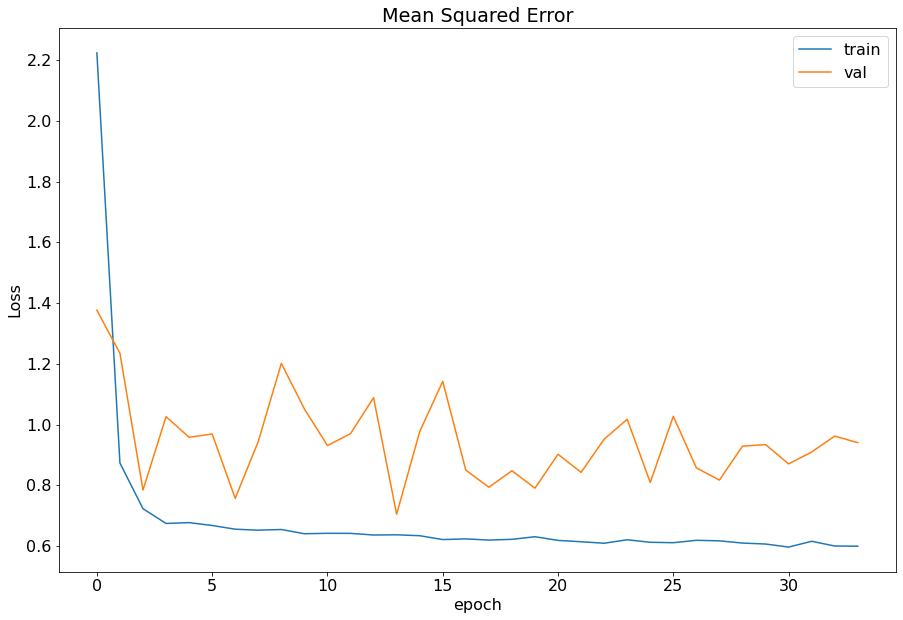

NN: 0.43242753533589967


In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

plt.rcParams.update({'font.size': 16})

def plot_hist(hist, figsize=(15,10)):
  plt.figure(figsize=figsize)
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('Mean Squared Error')
  plt.ylabel('Loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='best')
  plt.show()

plot_hist(hist)
print("NN:", mean_squared_error(ytest, mdl.predict(Xtest)))

Looks good, what about a challenger model?

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(
    n_estimators=250,
    max_leaf_nodes=16)

rfr.fit(Xtrain, ytrain)

print("RandomForest:", mean_squared_error(ytest, rfr.predict(Xtest)))
print("NN:", mean_squared_error(ytest, mdl.predict(Xtest)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForest: 0.37692267446695316
NN: 0.43242753533589967


Well, seems like we are going to use the Random Forest model!

But wait a second, Business is not so happy with the model, they don't want a model that optimizes the mean-squared error, but more something like this:

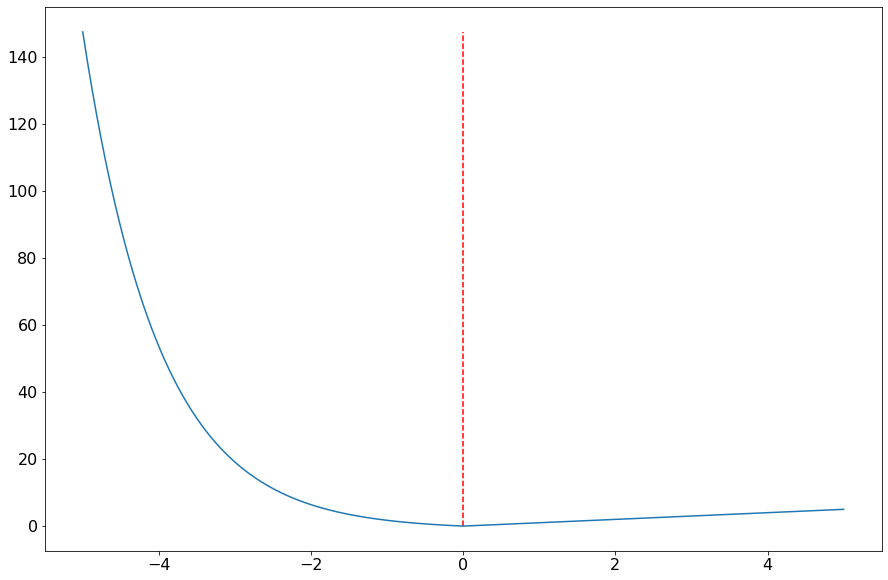

In [ ]:
def business_loss(y_true, y_pred):
  '''
  The loss business wants us to use, because overestimating the housing price
  is way more critical than underestimating it!
  '''
  error = y_true - y_pred

  lin_loss = tf.abs(error)
  exp_loss = (tf.exp(tf.abs(error)) - 1)

  return tf.where(error < 0.0, exp_loss, lin_loss)

def mean_business_loss(y_true, y_pred):
  bls = business_loss(y_true, y_pred)
  return tf.reduce_mean(bls)

# Ok, how does that look like

x_vals = tf.linspace(-5, 5, num=500)
err = business_loss(x_vals, tf.zeros_like(x_vals))

plt.figure(figsize=(15,10))
plt.plot(x_vals, err)
plt.vlines(0.0, ymin=0, ymax=tf.reduce_max(err), colors="red", linestyles="--")

Ok, so how are our models performing under this new metric/loss

Q: What is the difference between metric and loss?

In [ ]:
print("Random Forest:", mean_business_loss(ytest, rfr.predict(Xtest)))
print("NN:", mean_business_loss(ytest, mdl.predict(Xtest)))

Random Forest: tf.Tensor(1.6245153666147916, shape=(), dtype=float64)
NN: tf.Tensor(0.590431953663324, shape=(), dtype=float64)


Well, that is a nice surprise, our NN model is already better than the RF, but can we improve the results? Every dime counts!

In [ ]:
mdl.compile(
    loss=business_loss, 
    metrics=["mean_absolute_percentage_error"])

# Interestingly, this training reuses the weights from the previous training,
# if you have not overwritten the mdl variable with a new model definition.
mdl.fit(
    x=Xtrain, 
    y=ytrain, 
    batch_size=128, 
    epochs=100, 
    validation_split=0.2,
    callbacks=[
      EarlyStopping(patience=10, restore_best_weights=True),
      ModelCheckpoint("best_model_bls.h5", save_best_only=True)         
    ])

Epoch 1/100
107/107 [==============================] - 1s 9ms/step - loss: 0.6766 - mean_absolute_percentage_error: 741.9594 - val_loss: 0.9514 - val_mean_absolute_percentage_error: 217.8079
Epoch 2/100
107/107 [==============================] - 1s 8ms/step - loss: 0.6444 - mean_absolute_percentage_error: 330.7390 - val_loss: 0.8509 - val_mean_absolute_percentage_error: 191.3712
Epoch 3/100
107/107 [==============================] - 1s 7ms/step - loss: 0.6429 - mean_absolute_percentage_error: 793.7183 - val_loss: 0.8753 - val_mean_absolute_percentage_error: 209.5631
Epoch 4/100
107/107 [==============================] - 1s 7ms/step - loss: 0.6383 - mean_absolute_percentage_error: 610.0640 - val_loss: 0.8865 - val_mean_absolute_percentage_error: 257.7312
Epoch 5/100
107/107 [==============================] - 1s 7ms/step - loss: 0.6421 - mean_absolute_percentage_error: 293.6042 - val_loss: 1.0124 - val_mean_absolute_percentage_error: 326.7119
Epoch 6/100
107/107 [========================

In [ ]:
print("Random Forest:", mean_business_loss(ytest, rfr.predict(Xtest)))
print("NN:", mean_business_loss(ytest, mdl.predict(Xtest)))

Random Forest: tf.Tensor(1.6245153666147916, shape=(), dtype=float64)
NN: tf.Tensor(0.5607875440601103, shape=(), dtype=float64)


In case that you do not believe my claim that tensorflow and pytorch are converging more and more: The same model definition in pytorch

In [ ]:
import torch
import torch.nn as nn

mdl_pyt = nn.Sequential(
    nn.Dropout(0.25)
    , nn.Linear(Xtrain.shape[1], 125)
    , nn.ELU()
    , nn.BatchNorm1d(125)
    , nn.Dropout(0.25)
    , nn.Linear(125, 50)
    , nn.BatchNorm1d(50)
    , nn.ELU()
    , nn.Dropout(0.25)
    , nn.Linear(50, 1)
)

In [ ]:
mdl_pyt.eval()
mdl_pyt(torch.FloatTensor(Xtrain))

tensor([[-0.0311],
        [-0.1326],
        [ 0.2578],
        ...,
        [ 0.2166],
        [ 0.1845],
        [ 0.3309]], grad_fn=<AddmmBackward>)

In [ ]:
mdl(Xtrain, training=True)

<tf.Tensor: shape=(17000, 1), dtype=float32, numpy=
array([[-1.6473341],
       [-1.2307119],
       [-1.402904 ],
       ...,
       [-0.1330949],
       [-1.1942316],
       [-0.374106 ]], dtype=float32)>

Q: Repeatedly executing the above code reveals a rather peculiar behaviour, what could be the reason for it?

### Example 3 - The Functional API

Sequentially stacking different modules is nice, but what about if we want to use a model which is not sequentially organized? Functional API

In the previous example, we have sent all the data through a complicated NN, but couldn't it be that some of the original variables are already fairly predictive and all this transforming actually costs us predictive power? Never forget, the RF was way better than the NN!

In [ ]:
mdl.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 1000)              9000      
_________________________________________________________________
batch_normalization (BatchNo (None, 1000)              4000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 125)               125125    
_________________________________________________________________
batch_normalization_1 (Batch (None, 125)               500       
_________________________________________________________________
dropout_2 (Dropout)          (None, 125)               0

In [ ]:
mdl.pop()
mdl.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 1000)              9000      
_________________________________________________________________
batch_normalization (BatchNo (None, 1000)              4000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 125)               125125    
_________________________________________________________________
batch_normalization_1 (Batch (None, 125)               500       
_________________________________________________________________
dropout_2 (Dropout)          (None, 125)               0

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

orig_data = Input(shape=Xtrain.shape[1], name="data")
deep_fts = mdl(orig_data)

concat = tf.keras.layers.concatenate([deep_fts, orig_data])

res = Dense(25, activation="elu")(concat)
res = Dense(1)(res)

model = Model(
    inputs=[orig_data],
    outputs=[res])

As the term inputs and outputs imply, you can define multiple inputs and outputs. The outputs can have different loss functions and you would combine their losses via loss_weights-parameter in the model.compile step. 

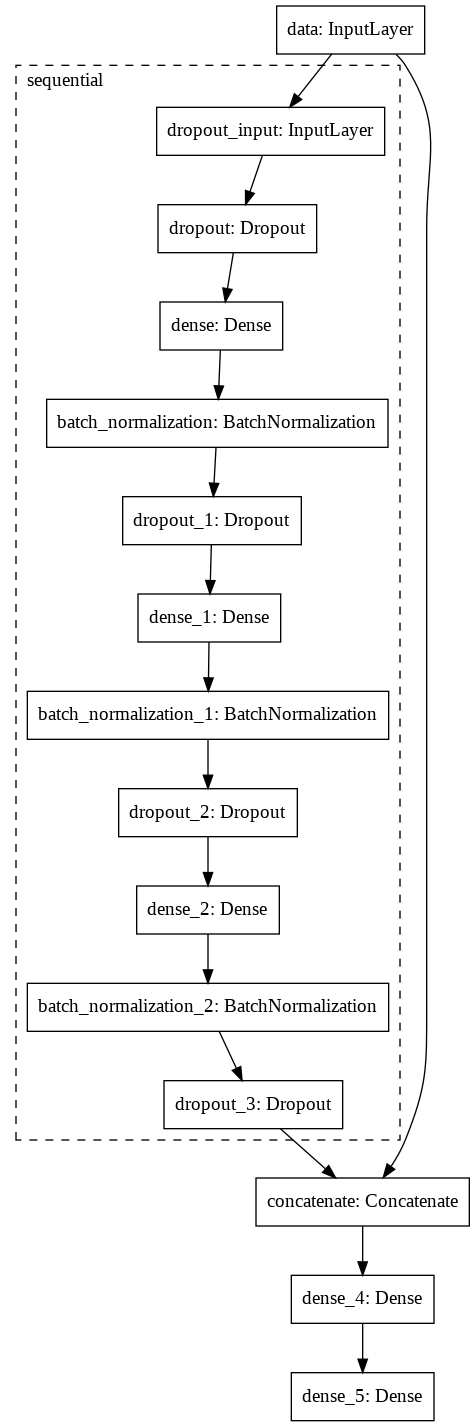

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, expand_nested=True)

In [ ]:
model.compile(
    loss="mse", 
    optimizer=tf.keras.optimizers.Adam())

In [ ]:
hist = model.fit(
    x=Xtrain, # If you have multiple ones: (Xtrain, Xtrain)
    y=ytrain,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
      EarlyStopping(patience=25, restore_best_weights=True),
      ModelCheckpoint("best_model_bls.h5", save_best_only=True)         
    ]
)

Epoch 1/100
425/425 [==============================] - 2s 5ms/step - loss: 0.5601 - val_loss: 0.5642
Epoch 2/100
425/425 [==============================] - 2s 4ms/step - loss: 0.4137 - val_loss: 0.5009
Epoch 3/100
425/425 [==============================] - 2s 4ms/step - loss: 0.3947 - val_loss: 0.4546
Epoch 4/100
425/425 [==============================] - 2s 4ms/step - loss: 0.3856 - val_loss: 0.5437
Epoch 5/100
425/425 [==============================] - 2s 4ms/step - loss: 0.3787 - val_loss: 0.5309
Epoch 6/100
425/425 [==============================] - 2s 4ms/step - loss: 0.3618 - val_loss: 0.5966
Epoch 7/100
425/425 [==============================] - 2s 4ms/step - loss: 0.3650 - val_loss: 0.4335
Epoch 8/100
425/425 [==============================] - 2s 4ms/step - loss: 0.3473 - val_loss: 0.4235
Epoch 9/100
425/425 [==============================] - 2s 4ms/step - loss: 0.3470 - val_loss: 0.4928
Epoch 10/100
425/425 [==============================] - 2s 4ms/step - loss: 0.3407 - val_lo

In [ ]:
print("Random Forest:", mean_business_loss(ytest, rfr.predict(Xtest)))
print("NN:", mean_business_loss(ytest, model.predict(Xtest)))

Random Forest: tf.Tensor(1.6245153666147916, shape=(), dtype=float64)
NN: tf.Tensor(0.4425990219098041, shape=(), dtype=float64)


### Example - Bag of Transactions Models - Incomplete :(

Let's say we want to develop a model which takes into account all the transactions of different customers and associates them with some target. E.g. the last 3 months of transactions and whether a customer was considered to be suspicious with respect to money laundering or fraud, or whether they have bought some product or churned, or whatever :)

We could simply use aggregations as features, but there might be some interest in identifying individual transactions. RNNs could do that, but they also assume sequential dependence between transactions, while this does not necessarily be the case.

How about some attention? :)

#### A very quick primer in Attention:

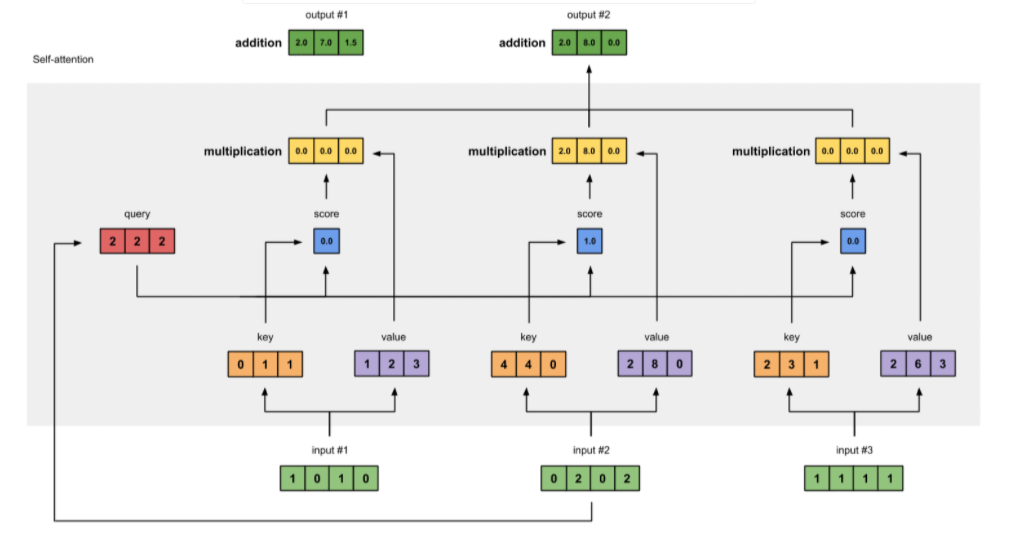



In [ ]:
from tensorflow.keras.layers import Attention, Embedding, Flatten, GlobalAveragePooling1D

# Disclaimer: What definitely does not work in this example:
# - Attention layer in tf.keras does not have all the necessary features yet
# - Dimensions are not taken care of :)

# Input would be a ragged tensor containing the different transactions of the
# customers, each tensor inside the ragged is assumet to be an integer-encoded
# categorical matrix 
inp = Input(shape=..., name="data")

val_emb = Embedding(
  input_dim=512,
  output_dim=50)
value_embed = val_emb(inp)

qry_emb = Embedding(
  input_dim=512,
  output_dim=50)
qry_embed = qry_emb(inp)

# Attention does not work this way atm
attent_value, scores = Attention(causal=False)(
  [qury_embed, value_embed],
  return_attention_scores=True)

# Reduce all the 50dim value vectors to one 50dim vector 
self_qury = GlobalAveragePooling1D()(
    attent_value)

# Attention round 2 :)
# If it would work, the outcome would be one 50dim vector
attent_value, scores = Attention(causal=False)(
  [self_qry, value_embed],
  return_attention_scores=True)

fts = Flatten()(attent_value)
probs = tf.nn.softmax(scores)

hidden = Dense(128, activation="elu")(fts)
hidden = Dense(64, activation="elu")(hidden)
res = Dense(1, activation="softmax")(hidden)

model = Model(
  inputs=[input],
  outputs=res)

### What's next?

This was just a brief glimpse into the world of tensorflow. Just a number of things which we have not even touched yet:

1. Subclassing API for more customization
2. Loading/preprocessing of data
3. Special purpose tools for e.g. RNN, CNN, GNN
4. Reinforcement Learning landscape (tf.agents)
5. Deployment support
6. and so on ... 

#Any Questions?